This notebook is an attempt to deal with the House Prices - Advanced Regression Techniques Kaggle competition.

In [21]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from pathlib import Path
import sys

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

from src.utils import detect_outliers_zscore, detect_outliers_residuals, detect_outliers_cook, combine_vote_outliers, detect_outliers_iforest

# 1. Data Visualization 

In [22]:
# import the Data
train_df = pd.read_csv("../Data/train.csv")
test_df = pd.read_csv("../Data/test.csv")

In [23]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [24]:
# numerical columns 
num_col = train_df.select_dtypes(include=[np.number]).columns.difference(['Id'])
features = [col for col in num_col if col != "SalePrice"]

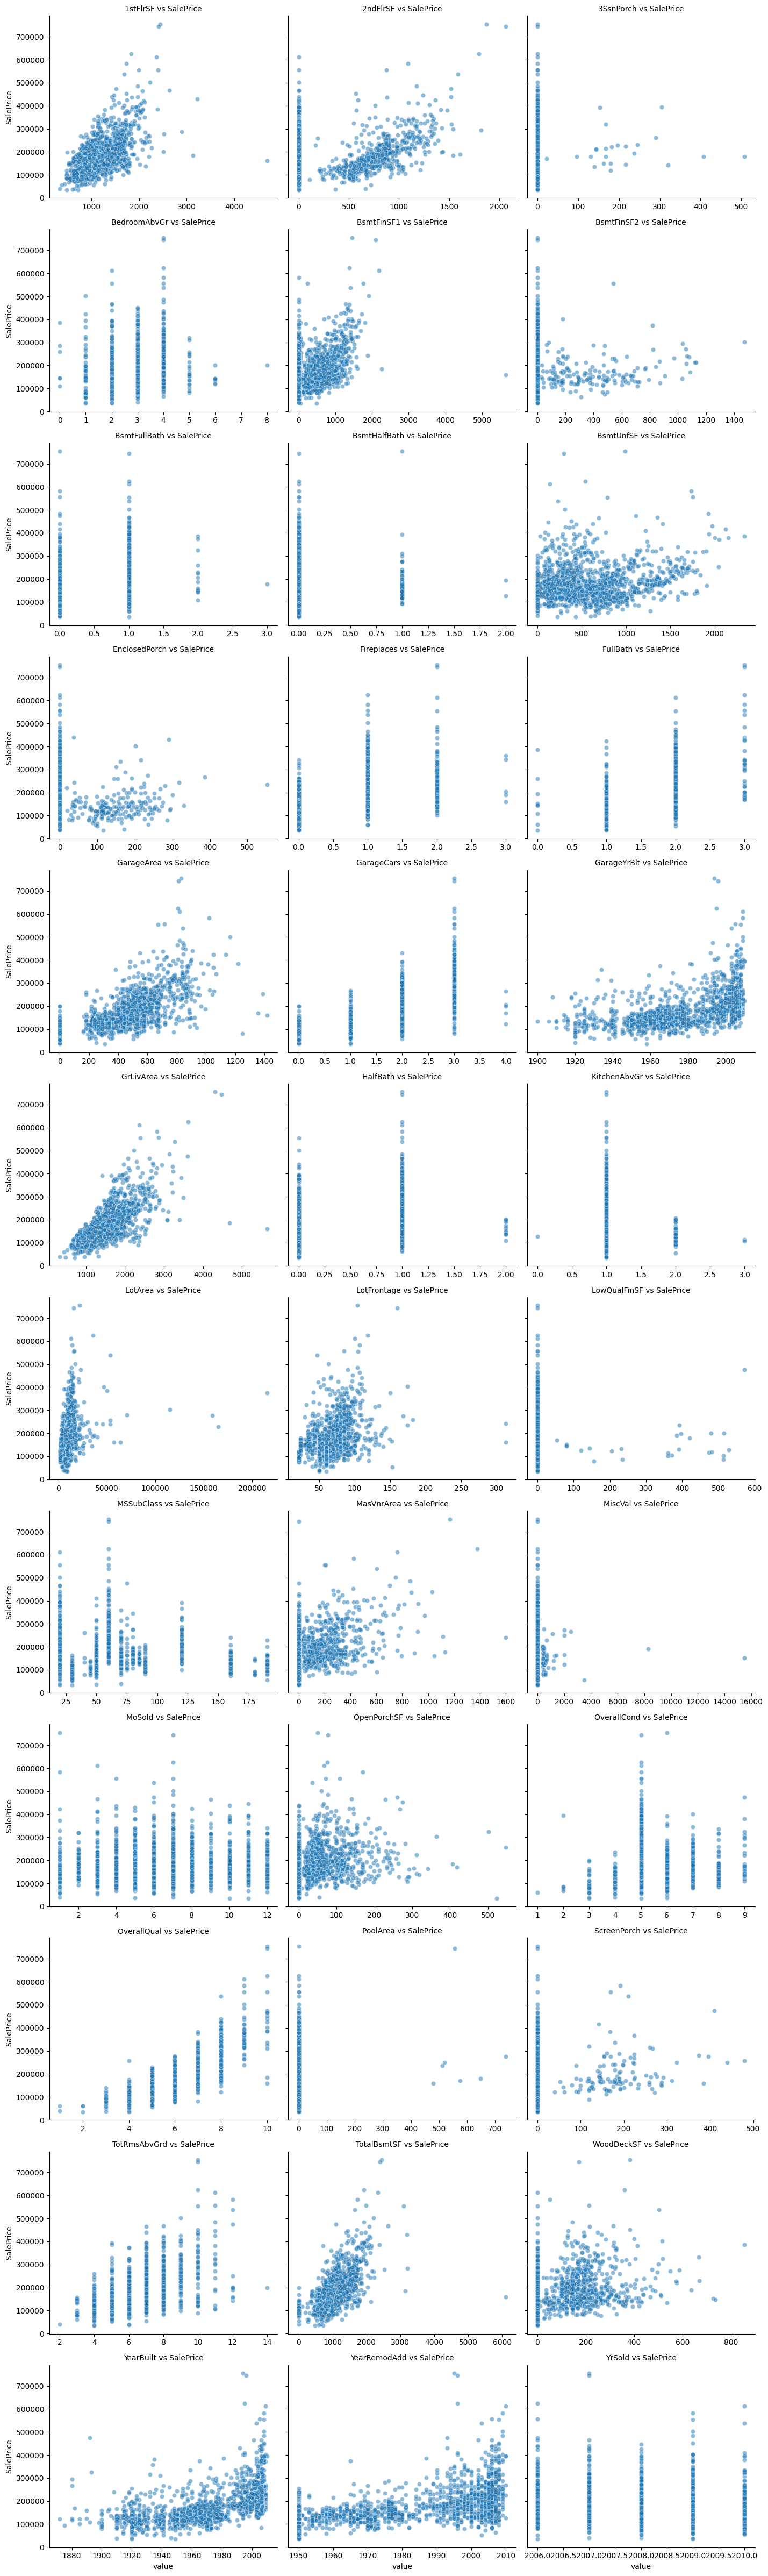

In [25]:
# Pivot the data to a 'long' format
melted_df = train_df.melt(id_vars=['SalePrice'], value_vars=features)

g = sns.relplot(
    data=melted_df, 
    x="value", y="SalePrice", 
    col="variable", col_wrap=3, 
    kind="scatter", facet_kws={'sharex': False},
    alpha=0.5, height=4, aspect=1.2
)

g.set_titles("{col_name} vs SalePrice")
plt.show()

# 2. Remove Outliers

In [26]:
train_df["LogLotArea"] = np.log1p(train_df["LotArea"])
train_df["LogSalePrice"] = np.log1p(train_df["SalePrice"])

test_df["LogLotArea"] = np.log1p(train_df["LotArea"])



core_features = [
    "OverallQual",   # strongest single predictor
    "GrLivArea",     # size above ground
    "TotalBsmtSF",   # basement size
    "YearBuilt",     # age proxy
    "LogLotArea",    # log to reduce the noise
]

In [27]:
r_resid = detect_outliers_residuals(
    train_df,
    x_cols=core_features,
    y_col="SalePrice",
    log_y=True,
    threshold=3.5
)

r_cook = detect_outliers_cook(
    train_df,
    x_cols=core_features,
    y_col="SalePrice",
    log_y=True
)


r_iforest = detect_outliers_iforest(
    train_df,
    x_cols=core_features + ["LogSalePrice"],
    contamination = 0.01
)

summary = combine_vote_outliers(
    [r_resid, r_cook, r_iforest],
    min_votes=2
)

outlier_ids = summary.loc[summary["is_outlier"], "Id"].tolist()

print(f'The number of outliers detected is {len(outlier_ids)} out of {len(train_df)}')

The number of outliers detected is 16 out of 1460


In [28]:
# remove them
train_df = train_df.loc[~train_df["Id"].isin(outlier_ids)].reset_index(drop=True)

# 3. Handling Nan Values

In [29]:
# Checking the col with nan values
pd.DataFrame(train_df.isnull().sum().sort_values(ascending = False)).head(19)

,0
PoolQC,1438
MiscFeature,1391
Alley,1354
Fence,1168
MasVnrType,860
FireplaceQu,681
LotFrontage,259
GarageFinish,76
GarageCond,76
GarageYrBlt,76


In [30]:
nan_features = pd.DataFrame(train_df.isnull().sum().sort_values(ascending = False)).head(19).index

In [31]:
fill_no = ["PoolQC","MiscFeature","Alley","Fence","MasVnrType","FireplaceQu","GarageCond","GarageQual","GarageType","BsmtExposure","BsmtFinType2","BsmtQual","BsmtCond","BsmtFinType1"]
median_imp = ["LotFrontage"]

In [32]:
for c in fill_no :
    train_df[c].fillna("No",inplace=True)
    test_df[c].fillna("No",inplace=True)

/var/folders/wd/xzhz26212j9cpdrvtc4cjt500000gn/T/ipykernel_60682/1754310451.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[c].fillna("No",inplace=True)
/var/folders/wd/xzhz26212j9cpdrvtc4cjt500000gn/T/ipykernel_60682/1754310451.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

In [33]:
train_df["GarageYrBlt"].fillna(0,inplace=True)
train_df["Electrical"].fillna("SBrkr",inplace=True)
train_df["GarageFinish"].fillna("Unf")

test_df["GarageYrBlt"].fillna(0,inplace=True)
test_df["Electrical"].fillna("SBrkr",inplace=True)
test_df["GarageFinish"].fillna("Unf")

/var/folders/wd/xzhz26212j9cpdrvtc4cjt500000gn/T/ipykernel_60682/857234697.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["GarageYrBlt"].fillna(0,inplace=True)
/var/folders/wd/xzhz26212j9cpdrvtc4cjt500000gn/T/ipykernel_60682/857234697.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

0       Unf
1       Unf
2       Fin
3       Fin
4       RFn
       ... 
1454    Unf
1455    Unf
1456    Unf
1457    Unf
1458    Fin
Name: GarageFinish, Length: 1459, dtype: object

In [34]:
median_lotfrontage = train_df["LotFrontage"].median()
neighborhood_medians = train_df.groupby("Neighborhood")["LotFrontage"].median()

train_df["LotFrontage"] = train_df["LotFrontage"].fillna(train_df["Neighborhood"].map(neighborhood_medians))
train_df["LotFrontage"] = train_df["LotFrontage"].fillna(median_lotfrontage)

test_df["LotFrontage"] = test_df["LotFrontage"].fillna(test_df["Neighborhood"].map(neighborhood_medians))
test_df["LotFrontage"] = test_df["LotFrontage"].fillna(median_lotfrontage)


median_masvnrarea = train_df["MasVnrArea"].median()

train_df["MasVnrArea"] = train_df["MasVnrArea"].fillna(median_masvnrarea)

test_df["MasVnrArea"] = test_df["MasVnrArea"].fillna(median_masvnrarea)

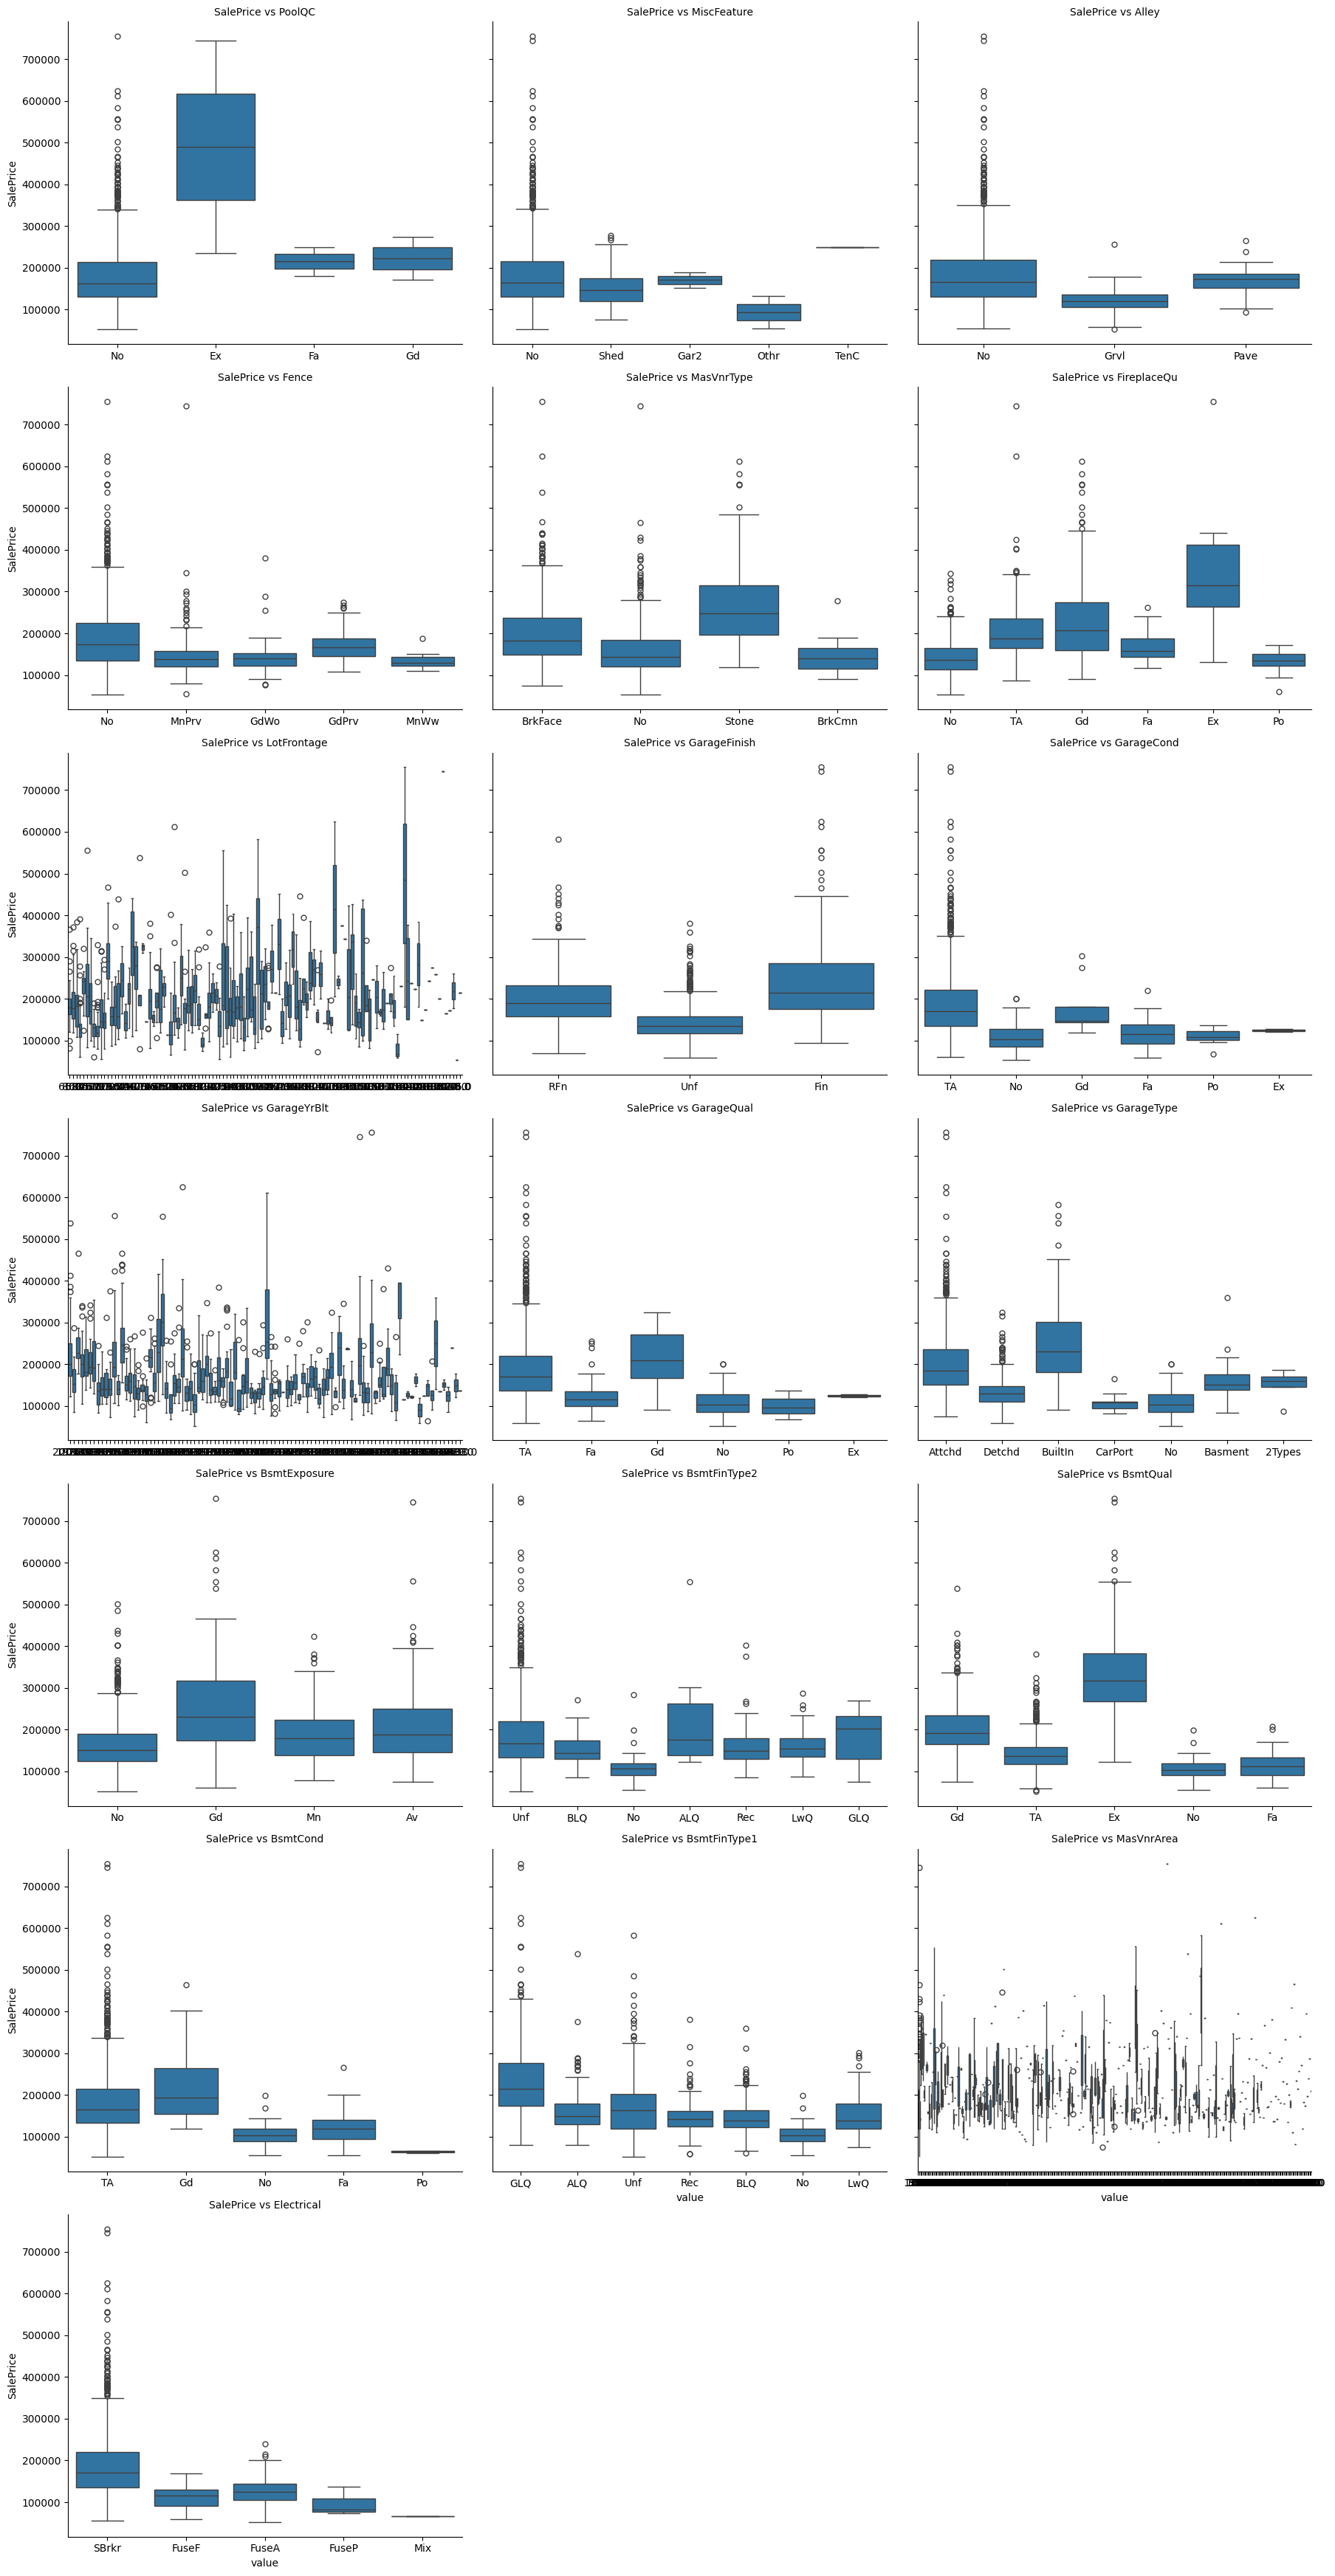

In [35]:
# plot the box-plot of the 'object' columns

melted_df1 = train_df.melt(id_vars=['SalePrice'], value_vars=nan_features)

g = sns.catplot(
    data=melted_df1, 
    x='value', 
    y='SalePrice', 
    col='variable', 
    kind='box', 
    col_wrap=3,
    sharex=False, 
    height=5, 
    aspect=1.2
)

g.set_titles("SalePrice vs {col_name}")

In [36]:
train_df.drop(columns = ["PoolQC","MiscFeature","Alley","Fence","GarageYrBlt","GarageCond","BsmtFinType2","GarageArea"],inplace=True)

test_df.drop(columns = ["PoolQC","MiscFeature","Alley","Fence","GarageYrBlt","GarageCond","BsmtFinType2","GarageArea"],inplace=True)

# 4. Feature Engineering

In [37]:
def feature_eng(df):
    df["totSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["BsmtFinSF1"] + df["BsmtFinSF2"]

    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]

    df["HouseNewAge"] = df["YrSold"] - df["YearRemodAdd"]

    df["TotalBath"] = df["FullBath"] + df["BsmtFullBath"] + 0.5*(df["BsmtHalfBath"] + df["HalfBath"])

    df["TotalArea"] = df["GrLivArea"] + df["TotalBsmtSF"]

    df["TotalPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]

    df.drop(columns = ["1stFlrSF","2ndFlrSF","BsmtFinSF1","BsmtFinSF2","YrSold","YearBuilt","YearRemodAdd","FullBath","BsmtFullBath","BsmtHalfBath","HalfBath","GrLivArea","TotalBsmtSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"], inplace = True)

    return df

In [38]:
train_df = feature_eng(train_df)

test_df = feature_eng(test_df)

In [39]:
train_df.drop(columns = ["Id"], inplace = True)

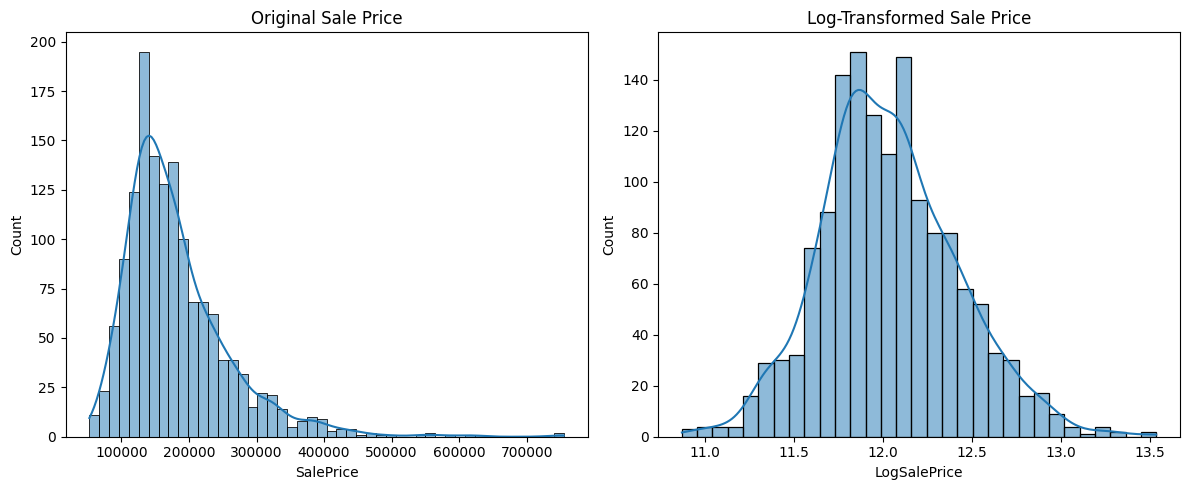

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=train_df, x="SalePrice", kde=True, ax=axes[0])
axes[0].set_title("Original Sale Price")

sns.histplot(data=train_df, x="LogSalePrice", kde=True, ax=axes[1])
axes[1].set_title("Log-Transformed Sale Price")

plt.tight_layout()
plt.show()

In [41]:
train_df.drop(columns = ["LotArea","SalePrice"], inplace = True)

test_df.drop(columns = ["LotArea"], inplace = True)

<Axes: >

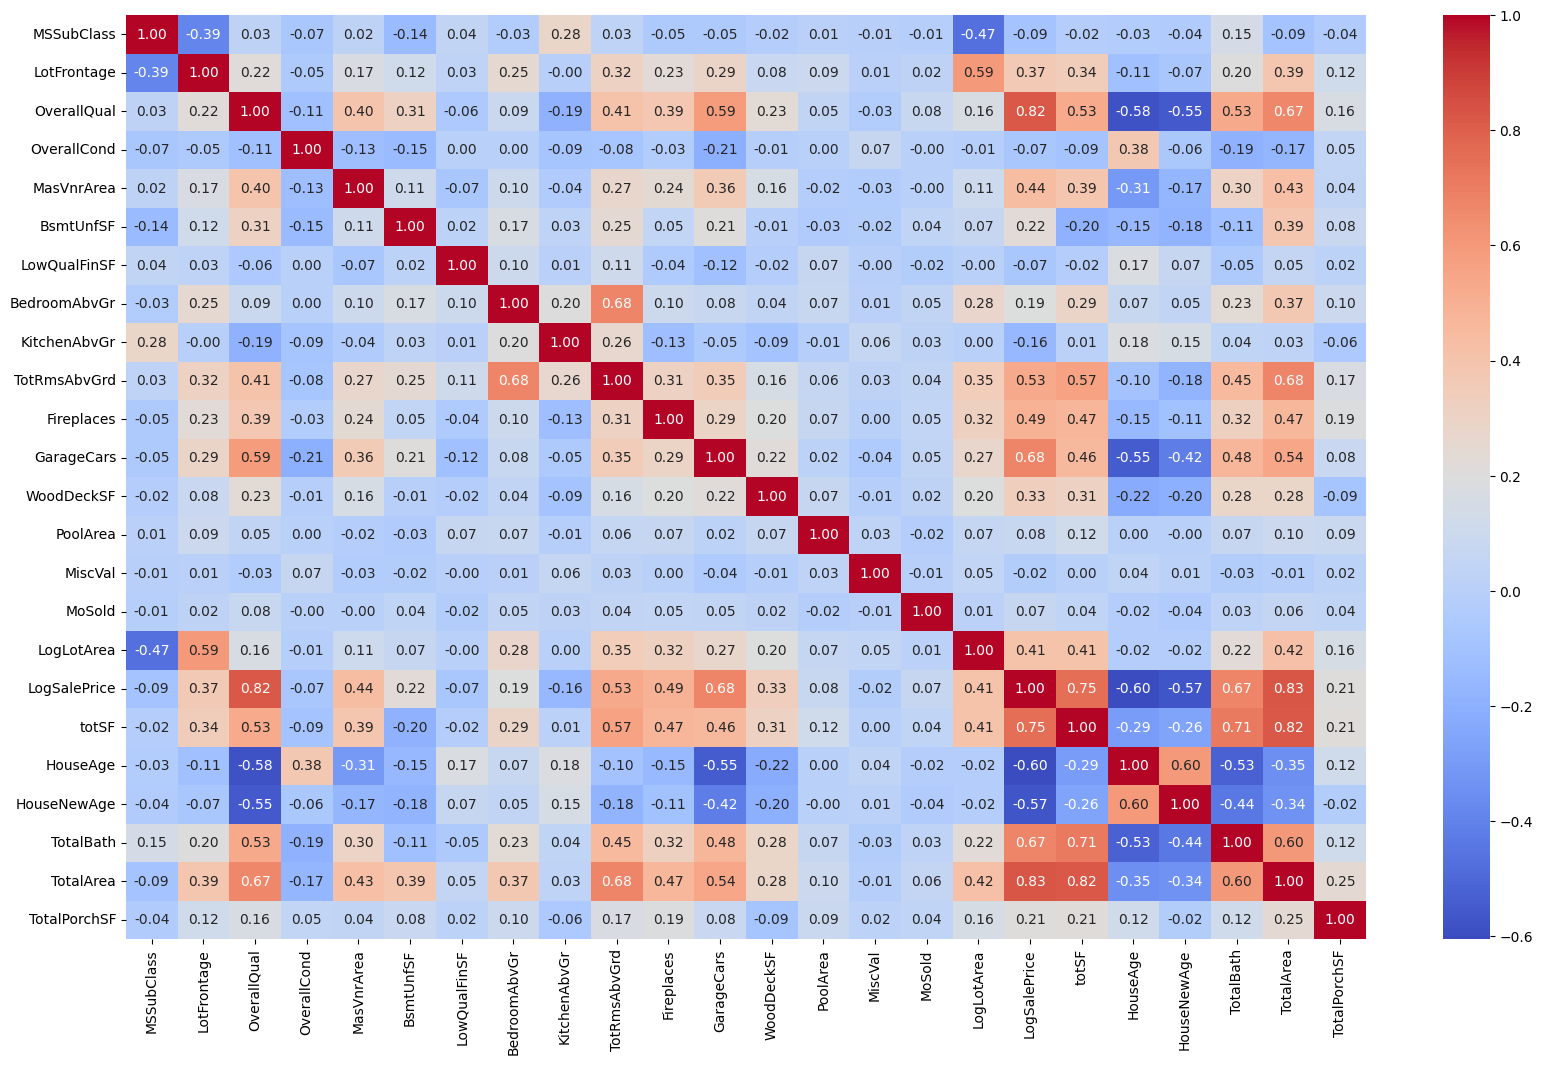

In [42]:
correlation_matrix = train_df.corr(numeric_only = True)
plt.figure(figsize = (20,12))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")

In [43]:
# Handling the 'object' columns either : ONE HOT ENCODING or ORDERED ENCODING 

ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('LogSalePrice')


Let's craft our final pipeline !

In [44]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [45]:
X = train_df.drop('LogSalePrice', axis=1)
y = train_df['LogSalePrice']

In [46]:
X_preprocessed = pipeline.fit_transform(X)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

# 5. Trying different models

1) Linear Regression OLS. 

In [48]:
lr = LinearRegression()

lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

In [49]:
np.sqrt(mean_squared_error(y_test,y_pred))

np.float64(0.11386980493084412)

2. Random Forest Regression

In [50]:
rfr = RandomForestRegressor(random_state=13)

param_grid_rfr = {
    'max_depth' : [5,10,15],
    'n_estimators' : [100,250,500],
    'min_samples_split' : [3,5,10]
}

rfr_cv = GridSearchCV(rfr,param_grid_rfr, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1)

rfr_cv.fit(X_train,y_train)


,estimator,RandomForestR...ndom_state=13)
,param_grid,"{'max_depth': [5, 10, ...], 'min_samples_split': [3, 5, ...], 'n_estimators': [100, 250, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,250


In [51]:
np.sqrt(-1*rfr_cv.best_score_)

np.float64(0.12232021998771897)

3. XGBOOST regression 

In [52]:
xgb = XGBRegressor(random_state=13)

param_grid_xgb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

xgb_cv = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

xgb_cv.fit(X_train, y_train)

,estimator,"XGBRegressor(...state=13, ...)"
,param_grid,"{'colsample_bytree': [0.8, 0.9, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.05, 0.1, ...], 'max_depth': [3], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [53]:
np.sqrt(-1 * xgb_cv.best_score_)

np.float64(0.10342183881058344)

4. Ridge Regression

In [54]:
ridge = Ridge()

param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

ridge_cv.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

,estimator,Ridge()
,param_grid,"{'alpha': [0.05, 0.1, ...], 'solver': ['auto', 'svd', ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,10


In [55]:
np.sqrt(-1 * ridge_cv.best_score_)

np.float64(0.09772565957522839)

5. Gradient Boosting Regression

In [56]:
gbr = GradientBoostingRegressor()

param_grid_gbr = {
    'max_depth': [12, 15, 20],
    'n_estimators': [200, 300, 1000],
    'min_samples_leaf': [10, 25, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_features': [0.01, 0.1, 0.7]
}

gbr_cv = GridSearchCV(gbr, param_grid_gbr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

gbr_cv.fit(X_train, y_train)

,estimator,GradientBoostingRegressor()
,param_grid,"{'learning_rate': [0.001, 0.01, ...], 'max_depth': [12, 15, ...], 'max_features': [0.01, 0.1, ...], 'min_samples_leaf': [10, 25, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [57]:
np.sqrt(-1 * gbr_cv.best_score_)

np.float64(0.10137972302689452)

6. Light GBM Regression

In [58]:
lgbm_regressor = lgb.LGBMRegressor(verbosity=-1)

param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

lgbm_cv.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skle

,estimator,LGBMRegressor(verbosity=-1)
,param_grid,"{'boosting_type': ['gbdt', 'dart'], 'learning_rate': [0.01, 0.05, ...], 'n_estimators': [100, 200, ...], 'num_leaves': [20, 30, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [59]:
np.sqrt(-1 * lgbm_cv.best_score_)

np.float64(0.1114857769690887)

7. CatBoost Regression

In [60]:
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)

param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

cat_cv = GridSearchCV(catboost, param_grid_cat, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

cat_cv.fit(X_train, y_train)

,estimator,<catboost.cor...t 0x16b916f80>
,param_grid,"{'depth': [4, 6, ...], 'iterations': [100, 500, ...], 'learning_rate': [0.01, 0.05, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [61]:
np.sqrt(-1 * cat_cv.best_score_)

np.float64(0.10207856016182912)

8. Voting Regression

In [62]:
vr = VotingRegressor([('gbr', gbr_cv.best_estimator_),
                      ('lgbm', lgbm_cv.best_estimator_),
                      ('ridge', ridge_cv.best_estimator_)],
                    weights=[2,3,1])

vr.fit(X_train, y_train)

y_pred_vr = vr.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [63]:
np.sqrt(mean_squared_error(y_test, y_pred_vr))

np.float64(0.11088892075412206)

9. Stacking Regression

In [64]:
estimators = [
    ('gbr', gbr_cv.best_estimator_),
    ('cat', cat_cv.best_estimator_),
    ('lgb', lgbm_cv.best_estimator_),
    ('rfr', rfr_cv.best_estimator_),
]

stackreg = StackingRegressor(
            estimators = estimators,
            final_estimator = vr
)

stackreg.fit(X_train, y_train)

y_pred_stack = stackreg.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skle

In [65]:
np.sqrt(mean_squared_error(y_test, y_pred_stack))

np.float64(0.11397660152230622)

# 6. Submitting the test file

1. Stack Regression

In [66]:
df_test_preprocess = pipeline.transform(test_df)

y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_df[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('stackReg_submission.csv', index=False)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/var/folders/wd/xzhz26212j9cpdrvtc4cjt500000gn/T/ipykernel_60682/3299551478.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['SalePrice'] = y_stacking
